In [141]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_score

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


In [142]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [143]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        feature, _= hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True, channel_axis=2)
        hog_features.append(feature)
    return np.array(hog_features)

hog_features_train = apply_hog_fixed(x_train)
hog_features_test = apply_hog_fixed(x_test)

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")

HOG Features Train Shape: (60000, 144)
HOG Features Test Shape: (10000, 144)


## 3.1

In [144]:
scaler = StandardScaler()

scaler.fit(x_train_pca)

x_train_pca_standardized = scaler.transform(x_train_pca)

x_test_pca_standardized = scaler.transform(x_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(hog_features_train)
x_test_hog_standardized = scaler_hog.transform(hog_features_test)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

# variance_threshold = VarianceThreshold(threshold=1)
# x_train_variance = variance_threshold.fit_transform(x_train_combined)
# x_test_variance = variance_threshold.transform(x_test_combined)

# print("Dimensiuni înainte și după Variance Threshold:")
# print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
# print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")


select_percentile = SelectPercentile(f_classif, percentile=35)
x_train_final = select_percentile.fit_transform(x_train_combined, y_train)
x_test_final = select_percentile.transform(x_test_combined)

print(f"Dimensiuni finale: Train: {x_train_final.shape}, Test: {x_test_final.shape}")



Dimensiuni finale: Train: (60000, 58), Test: (10000, 58)


In [145]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Transformă datele în tensori PyTorch
x_train_tensor = torch.Tensor(x_train_final)
x_test_tensor = torch.Tensor(x_test_final)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Creează DataLoader pentru train și test
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [146]:
import torch.nn as nn

# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_sizes, output_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_sizes[0])
#         self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.fc3 = nn.Linear(hidden_sizes[1], output_size)
#         self.relu = nn.ReLU()
#         # self.dropout = nn.Dropout(0.2)

# poti pune al doilea dropout aici la 3.2

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         # x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         # x = self.dropout(x)
#         x = self.fc3(x)
#         return x

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes, output_size)
        
    def forward(self, x):
        z = self.fc1(x)
        z = self.relu(z)
        z = self.fc2(z)
        return z

# Creează modelul
input_size = x_train_final.shape[1]  # Dimensiunea caracteristicilor
hidden_sizes = 100
output_size = 10  # 10 clase pentru Fashion-MNIST

model = MLP(input_size, hidden_sizes, output_size)



In [147]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Antrenare
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Testare
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs},\n Train Loss: {train_losses[-1]:.4f},\n Test Loss: {test_losses[-1]:.4f}, "
          f"\nTrain Acc: {train_accuracies[-1]:.4f},\n Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1/20,
 Train Loss: 2.1060,
 Test Loss: 1.9497, 
Train Acc: 0.2969,
 Test Acc: 0.3939
Epoch 2/20,
 Train Loss: 1.8079,
 Test Loss: 1.6785, 
Train Acc: 0.4317,
 Test Acc: 0.4651
Epoch 3/20,
 Train Loss: 1.5623,
 Test Loss: 1.4630, 
Train Acc: 0.4955,
 Test Acc: 0.5240
Epoch 4/20,
 Train Loss: 1.3726,
 Test Loss: 1.3016, 
Train Acc: 0.5551,
 Test Acc: 0.5788
Epoch 5/20,
 Train Loss: 1.2321,
 Test Loss: 1.1825, 
Train Acc: 0.6025,
 Test Acc: 0.6185
Epoch 6/20,
 Train Loss: 1.1282,
 Test Loss: 1.0936, 
Train Acc: 0.6360,
 Test Acc: 0.6428
Epoch 7/20,
 Train Loss: 1.0495,
 Test Loss: 1.0254, 
Train Acc: 0.6610,
 Test Acc: 0.6647
Epoch 8/20,
 Train Loss: 0.9884,
 Test Loss: 0.9718, 
Train Acc: 0.6785,
 Test Acc: 0.6778
Epoch 9/20,
 Train Loss: 0.9400,
 Test Loss: 0.9290, 
Train Acc: 0.6895,
 Test Acc: 0.6898
Epoch 10/20,
 Train Loss: 0.9006,
 Test Loss: 0.8943, 
Train Acc: 0.6986,
 Test Acc: 0.6965
Epoch 11/20,
 Train Loss: 0.8684,
 Test Loss: 0.8653, 
Train Acc: 0.7055,
 Test Acc: 0.70

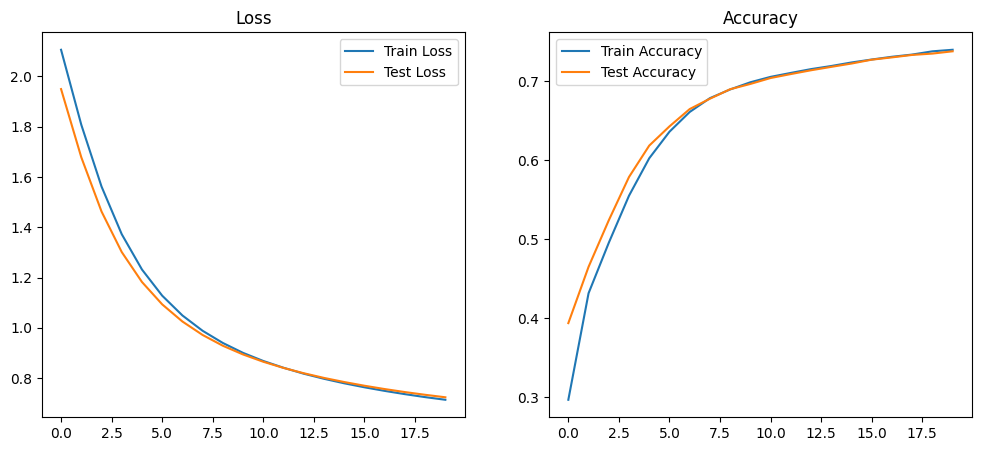

In [149]:
import matplotlib.pyplot as plt

# Curbele de pierdere
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Curbele de acuratețe
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [150]:
# from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# # Preziceri pe setul de test
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# print(classification_report(all_labels, all_preds))
# ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
# plt.show()


## 3.2

In [173]:
import torch.nn as nn

# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_sizes, output_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_sizes[0])  # Primul strat: 784 → 256
#         self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Al doilea strat: 256 → 128
#         self.fc3 = nn.Linear(hidden_sizes[1], output_size)  # Strat final: 128 → 10
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)  # Ultimul strat, fără activare (CrossEntropyLoss aplică softmax)
#         return x

# Inițializarea modelului



import torch
from torch.utils.data import DataLoader, TensorDataset

# Transformare în tensori PyTorch și liniarizare
x_train_tensor = torch.Tensor(x_train.reshape(x_train.shape[0], -1))
x_test_tensor = torch.Tensor(x_test.reshape(x_test.shape[0], -1))
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Crearea DataLoader-elor
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


input_size = x_train.shape[1] * x_train.shape[2]  # Dimensiunea imaginilor liniarizate
# hidden_sizes = [256, 128] # 100
# output_size = 10  # Număr de clase pentru Fashion-MNIST



In [198]:
model = MLP(input_size, hidden_sizes, output_size)

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Antrenare
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Testare
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")


cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 784x100)

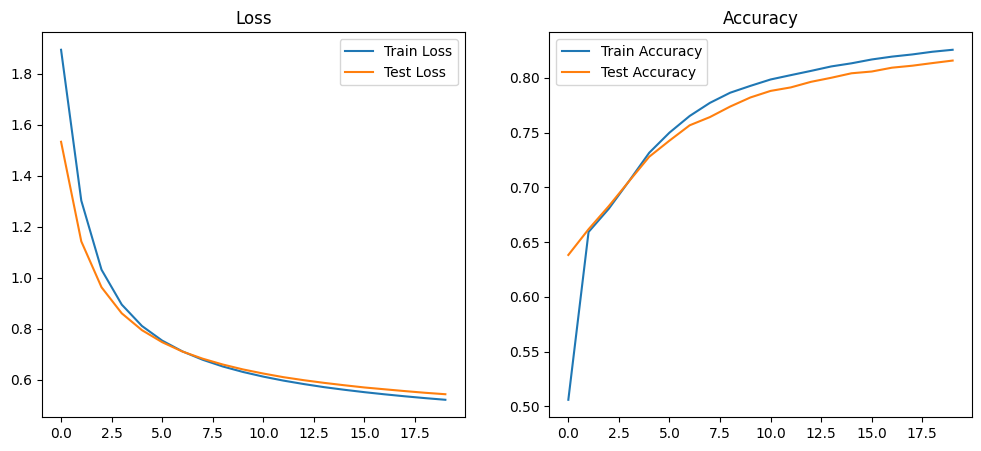

In [172]:
import matplotlib.pyplot as plt

# Curbele de pierdere
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Curbele de acuratețe
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


## 3.3

In [175]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [184]:
class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer=nn.BatchNorm2d):
        super(ConvBlock, self).__init__()

        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)

        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)

        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # first layer conv1 + bn1 + relu
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        # second layer conv2 + bn2 + relu
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        # third layer conv3 + bn3
        out = self.conv3(out)
        out = self.norm3(out)

        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out



In [185]:
class DeepConvNet(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, base_depth=16, expansion=4, nr_layer_blocks=1, num_classes=10):
        super(DeepConvNet, self).__init__()

        self.norm_layer = norm_layer
        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(nr_layer_blocks, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.norm1 = norm_layer(self.base_depth)
        self.relu = nn.ReLU(inplace=True)

        # change to 64 channels base and image size 16x16
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = norm_layer(depth1)

        # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        # TODO 3.1 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth2 = conv1x1(depth1, depth2)
        self.norm_depth2 = norm_layer(depth2)

        # #### Layer 2, 3 blocks
        # TODO 3.2 - Definiti secventa de ConvBlocks pentru Layer 2
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        # TODO 3.3 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth3 = conv1x1(depth2, depth3)
        self.norm_depth3 = norm_layer(depth3)

        # Layer 3, 3 blocks
        # TODO 3.4 - Definiti secventa de ConvBlocks pentru Layer 3
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # AveragePooling
        # TODO 3.5 - Definiti straturile de GlobalAveragePooling si stratul Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # initial conv
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        # TODO 3.6 apply depth1 transform + layer 1
        x = self.layer1(self.norm_depth1(self.conv_depth1(x)))
        # adauga droput
        # TODO 3.7 apply depth2 transform + layer 2
        x = self.layer2(self.norm_depth2(self.conv_depth2(x)))

        # TODO 3.8 apply depth3 transform + layer 3
        x = self.layer3(self.norm_depth3(self.conv_depth3(x)))

        # apply global average pooling + linearize + FC
        x = self.avgpool(x)
        x=x.view(-1, 256)
        x=self.fc(x)

        return x

In [191]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Transformare în tensori PyTorch și liniarizare
x_train_tensor = torch.Tensor(x_train).permute(0, 3, 1, 2)
x_test_tensor = torch.Tensor(x_test).permute(0, 3, 1, 2)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Crearea DataLoader-elor
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


input_size = x_train.shape[1] * x_train.shape[2]  # Dimensiunea imaginilor liniarizate

In [197]:
model = DeepConvNet(num_classes=10)
# print(model)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):

    # Antrenare
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        # print(f"Epoch {epoch+1}/{num_epochs}")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Testare
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")


cpu


KeyboardInterrupt: 

In [203]:
print(torch.__version__)

1.13.1+cpu


## 3.4